In [1]:
!python -V

Python 3.9.20


In [1]:
import pandas as pd

In [2]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [6]:
import mlflow


mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2024/10/29 03:43:47 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/mlops_zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1730173427741, experiment_id='1', last_update_time=1730173427741, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [7]:
df = pd.read_parquet('/workspaces/mlops_zoomcamp/data/green_tripdata_2024-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

np.float64(7.1228220948023795)

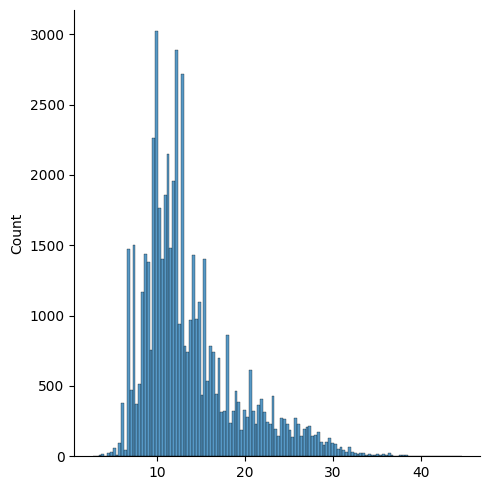

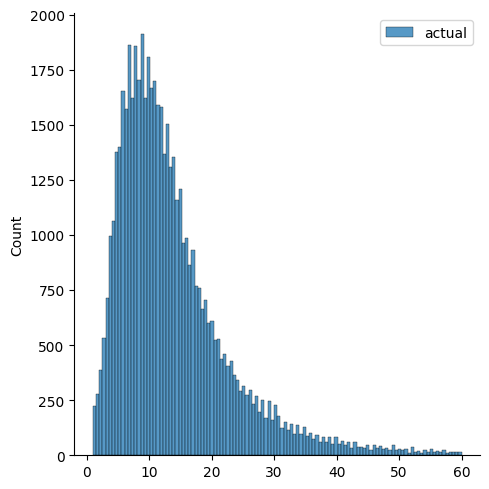

In [9]:
sns.displot(y_pred, label='prediction')
sns.displot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe('/workspaces/mlops_zoomcamp/data/green_tripdata_2024-01.parquet')
df_val = read_dataframe('/workspaces/mlops_zoomcamp/data/green_tripdata_2024-02.parquet')

In [12]:
len(df_train), len(df_val)

(54373, 51497)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

np.float64(5.9947992164797)

In [18]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [19]:
with mlflow.start_run():
    # Set tags and parameters
    mlflow.set_tag("developer", "christian")
    mlflow.log_param('train-data-path', "/workspaces/mlops_zoomcamp/data/green_tripdata_2024-01.parquet")
    mlflow.log_param('val-data-path', "/workspaces/mlops_zoomcamp/data/green_tripdata_2024-02.parquet")

    # Model training and evaluation
    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    # Log artifact
    mlflow.log_artifact(local_path="/workspaces/mlops_zoomcamp/02-experiment-tracking/models/lin_reg.bin", artifact_path="modeles_pickle")


In [22]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [23]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [24]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [25]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=Trials()
)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:47:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.16140                           
[1]	validation-rmse:6.19176                           
[2]	validation-rmse:5.70746                           
[3]	validation-rmse:5.49991                           
[4]	validation-rmse:5.41400                           
[5]	validation-rmse:5.35033                           
[6]	validation-rmse:5.34204                           
[7]	validation-rmse:5.33613                           
[8]	validation-rmse:5.33024                           
[9]	validation-rmse:5.32791                           
[10]	validation-rmse:5.32841                          
[11]	validation-rmse:5.32435                          
[12]	validation-rmse:5.32174                          
[13]	validation-rmse:5.31743                          
[14]	validation-rmse:5.31586                          
[15]	validation-rmse:5.31332                          
[16]	validation-rmse:5.31158                          
[17]	validation-rmse:5.31014                          
[18]	valid

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:47:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:5.47772                                                     
[4]	validation-rmse:5.44893                                                     
[5]	validation-rmse:5.43235                                                     
[6]	validation-rmse:5.42332                                                     
[7]	validation-rmse:5.41969                                                     
[8]	validation-rmse:5.41168                                                     
[9]	validation-rmse:5.40964                                                     
[10]	validation-rmse:5.40786                                                    
[11]	validation-rmse:5.40186                                                    
[12]	validation-rmse:5.39947                                                    
[13]	validation-rmse:5.39463                                                    
[14]	validation-rmse:5.39146                                                    
[15]	validation-rmse:5.39015

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:48:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.72568                                                    
[1]	validation-rmse:8.37515                                                    
[2]	validation-rmse:8.05833                                                    
[3]	validation-rmse:7.77082                                                    
[4]	validation-rmse:7.51282                                                    
[5]	validation-rmse:7.28035                                                    
[6]	validation-rmse:7.06964                                                    
[7]	validation-rmse:6.87364                                                    
[8]	validation-rmse:6.70570                                                    
[9]	validation-rmse:6.55441                                                    
[10]	validation-rmse:6.41508                                                   
[11]	validation-rmse:6.28870                                                   
[12]	validation-rmse:6.18080            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:49:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.68190                                                    
[1]	validation-rmse:6.74875                                                    
[2]	validation-rmse:6.15879                                                    
[3]	validation-rmse:5.79935                                                    
[4]	validation-rmse:5.58484                                                    
[5]	validation-rmse:5.45867                                                    
[6]	validation-rmse:5.38297                                                    
[7]	validation-rmse:5.33758                                                    
[8]	validation-rmse:5.31236                                                    
[9]	validation-rmse:5.29459                                                    
[10]	validation-rmse:5.28214                                                   
[11]	validation-rmse:5.27300                                                   
[12]	validation-rmse:5.26632            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:50:33] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.17999                                                    
[1]	validation-rmse:5.53281                                                    
[2]	validation-rmse:5.37140                                                    
[3]	validation-rmse:5.33889                                                    
[4]	validation-rmse:5.32359                                                    
[5]	validation-rmse:5.32350                                                    
[6]	validation-rmse:5.31735                                                    
[7]	validation-rmse:5.29694                                                    
[8]	validation-rmse:5.29662                                                    
[9]	validation-rmse:5.29221                                                    
[10]	validation-rmse:5.29029                                                   
[11]	validation-rmse:5.29113                                                   
[12]	validation-rmse:5.28994            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:50:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.50326                                                    
[1]	validation-rmse:7.98136                                                    
[2]	validation-rmse:7.53328                                                    
[3]	validation-rmse:7.15248                                                    
[4]	validation-rmse:6.82854                                                    
[5]	validation-rmse:6.55763                                                    
[6]	validation-rmse:6.32743                                                    
[7]	validation-rmse:6.13421                                                    
[8]	validation-rmse:5.97337                                                    
[9]	validation-rmse:5.83884                                                    
[10]	validation-rmse:5.72830                                                   
[11]	validation-rmse:5.63742                                                   
[12]	validation-rmse:5.56129            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:51:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.63618                                                    
[1]	validation-rmse:8.21107                                                    
[2]	validation-rmse:7.84265                                                    
[3]	validation-rmse:7.50553                                                    
[4]	validation-rmse:7.21997                                                    
[5]	validation-rmse:6.95734                                                    
[6]	validation-rmse:6.74008                                                    
[7]	validation-rmse:6.54849                                                    
[8]	validation-rmse:6.37033                                                    
[9]	validation-rmse:6.22339                                                    
[10]	validation-rmse:6.09616                                                   
[11]	validation-rmse:5.99361                                                   
[12]	validation-rmse:5.88880            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:53:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.05187                                                    
[1]	validation-rmse:6.10263                                                    
[2]	validation-rmse:5.70082                                                    
[3]	validation-rmse:5.53596                                                    
[4]	validation-rmse:5.45637                                                    
[5]	validation-rmse:5.41866                                                    
[6]	validation-rmse:5.39629                                                    
[7]	validation-rmse:5.38332                                                    
[8]	validation-rmse:5.37745                                                    
[9]	validation-rmse:5.37079                                                    
[10]	validation-rmse:5.35999                                                   
[11]	validation-rmse:5.35436                                                   
[12]	validation-rmse:5.35159            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:54:11] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.46637                                                    
[1]	validation-rmse:6.47229                                                    
[2]	validation-rmse:5.89907                                                    
[3]	validation-rmse:5.58164                                                    
[4]	validation-rmse:5.40607                                                    
[5]	validation-rmse:5.31487                                                    
[6]	validation-rmse:5.26734                                                    
[7]	validation-rmse:5.23604                                                    
[8]	validation-rmse:5.22131                                                    
[9]	validation-rmse:5.21092                                                    
[10]	validation-rmse:5.20229                                                   
[11]	validation-rmse:5.19762                                                   
[12]	validation-rmse:5.19293            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:54:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.29038                                                    
[1]	validation-rmse:7.63780                                                    
[2]	validation-rmse:7.12551                                                    
[3]	validation-rmse:6.72724                                                    
[4]	validation-rmse:6.42061                                                    
[5]	validation-rmse:6.18744                                                    
[6]	validation-rmse:6.01039                                                    
[7]	validation-rmse:5.87749                                                    
[8]	validation-rmse:5.77688                                                    
[9]	validation-rmse:5.70178                                                    
[10]	validation-rmse:5.64534                                                   
[11]	validation-rmse:5.60260                                                   
[12]	validation-rmse:5.57025            

In [26]:
mlflow.xgboost.autolog(disable=True)

In [27]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.48100410234773927,
        'max_depth': 9,
        'min_child_weight': 1.2298293383274017,
        'objective': 'reg:linear',
        'reg_alpha': 0.13293381844739885,
        'reg_lambda': 0.06411612779484911,
        'seed': 42
    }

    mlflow.log_params(best_params)

    mlflow.log_param('train-data-path', "/workspaces/mlops_zoomcamp/data/green_tripdata_2024-01.parquet")
    mlflow.log_param('val-data-path', "/workspaces/mlops_zoomcamp/data/green_tripdata_2024-02.parquet")

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[0]	validation-rmse:6.69858
[1]	validation-rmse:5.84436
[2]	validation-rmse:5.56773


/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:57:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[3]	validation-rmse:5.47772
[4]	validation-rmse:5.44893
[5]	validation-rmse:5.43235
[6]	validation-rmse:5.42332
[7]	validation-rmse:5.41969
[8]	validation-rmse:5.41168
[9]	validation-rmse:5.40964
[10]	validation-rmse:5.40786
[11]	validation-rmse:5.40186
[12]	validation-rmse:5.39947
[13]	validation-rmse:5.39463
[14]	validation-rmse:5.39146
[15]	validation-rmse:5.39015
[16]	validation-rmse:5.38267
[17]	validation-rmse:5.38063
[18]	validation-rmse:5.37751
[19]	validation-rmse:5.37135
[20]	validation-rmse:5.36875
[21]	validation-rmse:5.36784
[22]	validation-rmse:5.36148
[23]	validation-rmse:5.35962
[24]	validation-rmse:5.35654
[25]	validation-rmse:5.35386
[26]	validation-rmse:5.35123
[27]	validation-rmse:5.34841
[28]	validation-rmse:5.34531
[29]	validation-rmse:5.34406
[30]	validation-rmse:5.33812
[31]	validation-rmse:5.33694
[32]	validation-rmse:5.33082
[33]	validation-rmse:5.32790
[34]	validation-rmse:5.32667
[35]	validation-rmse:5.32571
[36]	validation-rmse:5.32367
[37]	validation-rmse:

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:57:55] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2024/10/29 03:57:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [28]:
logged_model = 'runs:/cac7a697e69b4cf3b9ccb63358d9a23f/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [29]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: cac7a697e69b4cf3b9ccb63358d9a23f

In [30]:
xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model

In [31]:
y_pred = xgboost_model.predict(valid)

In [32]:
y_pred[:10]

array([18.751312 , 28.17882  ,  7.9457946,  8.937255 ,  4.009926 ,
        4.604854 ,  9.395315 , 18.27346  , 22.480812 ,  6.8067527],
      dtype=float32)

In [33]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "/workspaces/mlops_zoomcamp/data/green_tripdata_2024-01.parquet")
        mlflow.log_param("valid-data-path", "/workspaces/mlops_zoomcamp/data/green_tripdata_2024-01.parquet")
        
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

2024/10/29 04:01:01 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
2024/10/29 04:04:55 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
2024/10/29 04:05:01 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
2024/10/29 04:12:05 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
